In [7]:
import os   
import sys
import yaml
import torch
import glob
import datetime
import pickle
import pytorch_lightning as pl
import torch.utils.data as data
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

sys.path.append('/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE')
from srsphere.diffusion.diffusion import Diffusion
from srsphere.diffusion.schedules import TimestepSampler, linear_beta_schedule
from srsphere.diffusion.ResUnet_timeembed import Unet
from srsphere.data.maploader import get_datasets, transform_combine
from srsphere.diffusion.main import initialize, Unet_pl

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
ckpt_path= "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/srsphere/diffusion/lightning_logs/version_5/checkpoints/Run_09-04_18-05epoch=286-val_loss=0.03.ckpt"

# load config

In [4]:
config_file = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/srsphere/diffusion/params.yaml"
config_dict = initialize(config_file)

pl.seed_everything(1234)

CONDITIONAL = bool(config_dict['data']['conditional'])
BATCH_SIZE = 48#config_dict['train']['batch_size']

[rank: 0] Global seed set to 1234


In [5]:
### get training data
map_dirs = [config_dict['data']['hrmaps_dir'], config_dict['data']['lrmaps_dir']]
nsides = [config_dict['data']['nside_hr'], config_dict['data']['nside_lr']]
data_lr, data_hr = get_datasets(map_dirs, config_dict['data']['n_maps'], nsides, config_dict['data']['order'], config_dict['data']['issplit'], config_dict['data']['normalize'])
combined_dataset = transform_combine(data_hr - data_lr, data_lr)

len_train = int(config_dict['data']['rate_train'] * len(data_hr))
len_val = len(data_hr) - len_train
train, val = data.random_split(combined_dataset, [len_train, len_val])
loaders = {x: data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=x=='train', num_workers=os.cpu_count()) for x, ds in zip(('train', 'val'), (train, val))}

train_loader, val_loader= loaders['train'], loaders['val']

In [8]:
mapdir_lr = glob.glob(map_dirs[1]+"*.fits")

In [9]:
timesteps = int(config_dict['diffusion']['timesteps'])

In [10]:
sampler = TimestepSampler(timesteps=timesteps, **config_dict['diffusion']['sampler_args'])

Sampler type uniform


# sampler

In [8]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [9]:
t = sampler.get_timesteps(48, 0).to(device)

In [10]:
t = torch.tensor(np.ones(BATCH_SIZE)*(timesteps-1), device=device).long()

In [11]:
timesteps = int(config_dict['diffusion']['timesteps'])
beta_func = linear_beta_schedule
beta_args = config_dict['diffusion']['schedule_args']
betas = beta_func(timesteps=timesteps, **beta_args)
tmp_diffusion = Diffusion(betas)

In [12]:
tmp_sample =combined_dataset.tensors[0][:BATCH_SIZE].to(device)
tmp_lr = combined_dataset.tensors[1][:BATCH_SIZE].to(device)

In [13]:
q_sample = tmp_diffusion.q_sample(tmp_sample, t)

In [14]:
diffused_sample = np.hstack(q_sample.detach().cpu().numpy()[:48, : , 0])
original_sample = np.hstack(tmp_sample.detach().cpu().numpy()[:48, : , 0])
lr_sample = np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0])

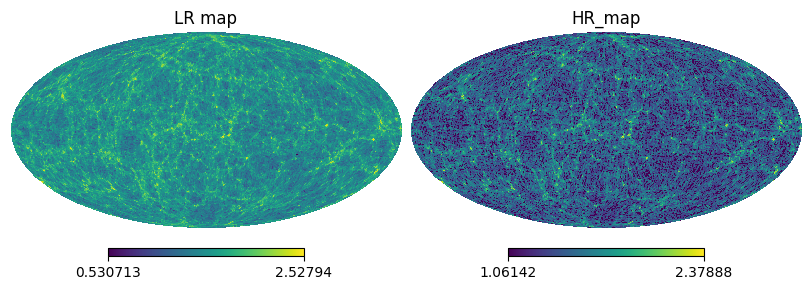

In [15]:
fig = plt.figure(figsize=(8,4))
p1 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR map', sub=(1,2,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,2,2))
fig.show()

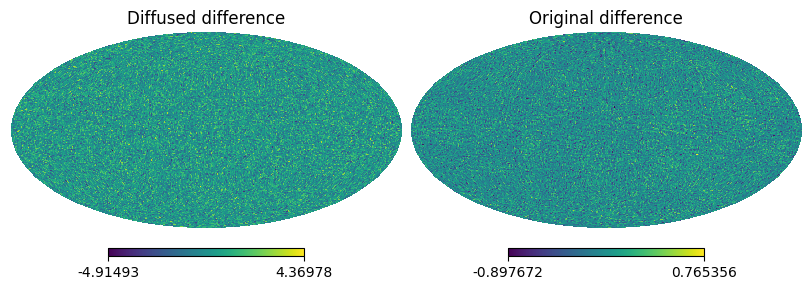

In [16]:
fig = plt.figure(figsize=(8,4))
p1 = hp.mollview(diffused_sample, nest=True, fig=fig, title='Diffused difference', sub=(1,2,1))
p2 = hp.mollview(original_sample, nest=True, fig=fig, title='Original difference', sub=(1,2,2))
fig.show()

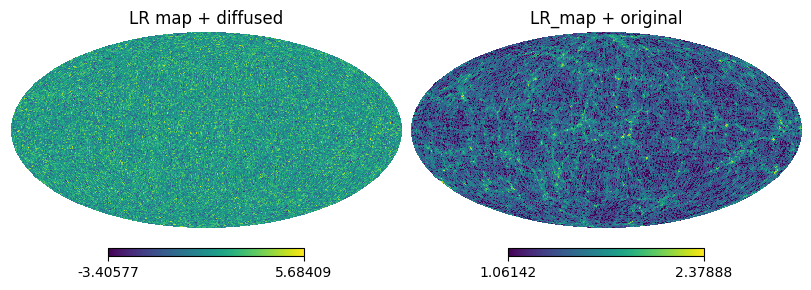

In [17]:
fig = plt.figure(figsize=(8,4))
p1 = hp.mollview(diffused_sample + lr_sample, nest=True, fig=fig, title='LR map + diffused', sub=(1,2,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='LR_map + original', sub=(1,2,2))
fig.show()

# load state dict

In [18]:
ckpt = torch.load(ckpt_path)

In [19]:
model = Unet_pl(Unet, config_dict, sampler = sampler).to(device)
model.load_state_dict(ckpt["state_dict"], strict=False)

_IncompatibleKeys(missing_keys=['model.init_conv.laplacian', 'model.init_conv_lr.laplacian', 'model.down_blocks.0.0.block1.conv.laplacian', 'model.down_blocks.0.0.block2.conv.laplacian', 'model.down_blocks.0.1.block1.conv.laplacian', 'model.down_blocks.0.1.block2.conv.laplacian', 'model.down_blocks.1.0.block1.conv.laplacian', 'model.down_blocks.1.0.block2.conv.laplacian', 'model.down_blocks.1.0.res_conv.laplacian', 'model.down_blocks.1.1.block1.conv.laplacian', 'model.down_blocks.1.1.block2.conv.laplacian', 'model.down_blocks.2.0.block1.conv.laplacian', 'model.down_blocks.2.0.block2.conv.laplacian', 'model.down_blocks.2.0.res_conv.laplacian', 'model.down_blocks.2.1.block1.conv.laplacian', 'model.down_blocks.2.1.block2.conv.laplacian', 'model.down_blocks.3.0.block1.conv.laplacian', 'model.down_blocks.3.0.block2.conv.laplacian', 'model.down_blocks.3.0.res_conv.laplacian', 'model.down_blocks.3.1.block1.conv.laplacian', 'model.down_blocks.3.1.block2.conv.laplacian', 'model.mid_block1.block

In [20]:
model.eval()

Unet_pl(
  (model): Unet(
    (pooling): HealpixAvgPool(kernel_size=(4,), stride=(4,), padding=(0,))
    (unpooling): HealpixAvgUnpool()
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=64, out_features=64, bias=True)
    )
    (init_conv): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (init_conv_lr): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (down_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock_t(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=64, out_features=64, bias=True)
          )
          (block1): Block(
            (conv): SphericalChebConv(
              (chebconv): ChebConv()
            )
            (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            (act): LeakyReLU(negative_slope=0.1)
          )
          (block2): Bl

# test

In [21]:
from tqdm.auto import tqdm

In [28]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

In [35]:
def plot_ps(input_cl, output_cl, target_cl):
    fig = plt.figure(figsize=(10, 5))
    ell = np.arange(len(input_cl))
    plt.plot(ell*(ell+1)*input_cl/(2*np.pi), label="input")
    plt.plot(ell*(ell+1)*output_cl/(2*np.pi), label="output")
    plt.plot(ell*(ell+1)*target_cl/(2*np.pi), label="target")
    #plt.ylim(0,2)
    plt.xlabel("l", fontsize=16)
    plt.ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=16)
    plt.yscale("log")
    plt.legend(fontsize=16)
    plt.show()

In [25]:
q_sample = tmp_diffusion.q_sample(tmp_sample, torch.full((BATCH_SIZE,), timesteps-1, device=device))

In [43]:
img = torch.randn(tmp_sample.shape, device=device)
imgs = []

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((BATCH_SIZE,), i, device=device, dtype=torch.long)
    img = tmp_diffusion.p_sample(model.model, img, t, tmp_lr, i)
    imgs.append(img.detach().cpu().numpy()[:48, : , 0])

sampling loop time step: 100%|██████████| 1000/1000 [19:44<00:00,  1.18s/it]


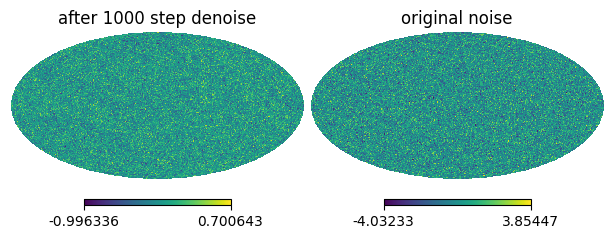

In [50]:
fig = plt.figure(figsize=(6,4))
f1 = hp.mollview(np.hstack(imgs[-1]), nest=True, fig=fig, title='after 1000 step denoise', sub=(1,2,1))
f2 = hp.mollview(np.hstack(imgs[0]), nest=True, fig=fig, title='original noise', sub=(1,2,2))

In [51]:
res=np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0]) + np.hstack(imgs[-1])

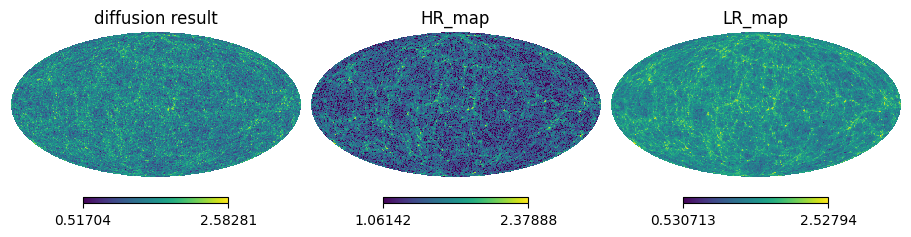

In [52]:
fig = plt.figure(figsize=(9,4))
p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,3,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,3,2))
p3 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR_map', sub=(1,3,3))
fig.show()

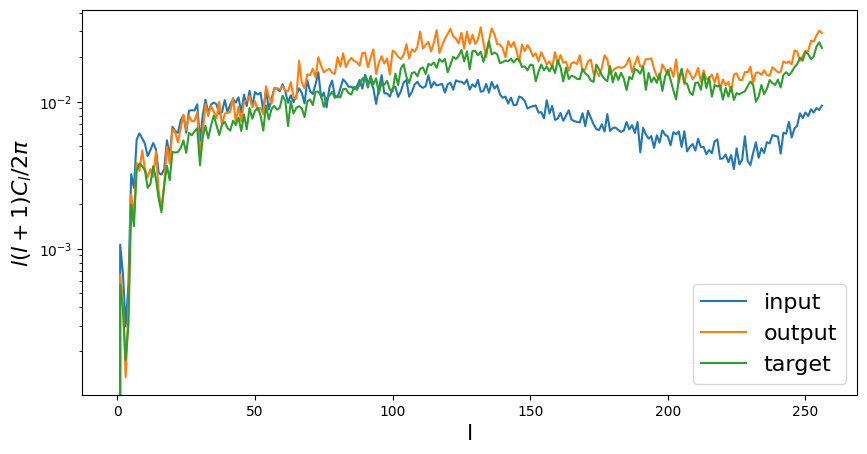

In [58]:
lmax = 64*4

input_cl =hp.sphtfunc.anafast(t2hpr(lr_sample), lmax=lmax)
output_cl =hp.sphtfunc.anafast(t2hpr(res), lmax=lmax)
target_cl =hp.sphtfunc.anafast(t2hpr(original_sample + lr_sample), lmax=lmax)

plot_ps(input_cl, output_cl, target_cl)

In [44]:
n = 5
tick = 500//n
for i in range(n):
    fig = plt.figure(figsize=(4,4))
    c = hp.mollview(np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0])+imgs[tick*i], nest=True,  fig=fig)
    plt.show()

ValueError: operands could not be broadcast together with shapes (49152,) (48,1024) 

<Figure size 400x400 with 0 Axes>

In [26]:
diffused_sample = np.hstack(q_sample.detach().cpu().numpy()[:48, : , 0])

In [36]:
img = q_sample.detach()
imgs=[np.hstack(img.detach().cpu().numpy()[:48, : , 0])]

In [37]:
i = 999
t = torch.full((BATCH_SIZE,), i, device=device, dtype=torch.long)
predicted_noise = model.model(img, t, tmp_lr)
img = (img - predicted_noise)
imgs.append(np.hstack(img.detach().cpu().numpy()[:48, : , 0]))
del predicted_noise 
torch.cuda.empty_cache()

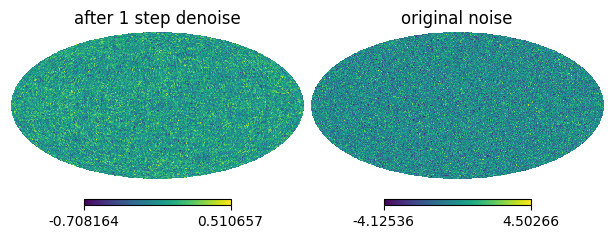

In [38]:
fig = plt.figure(figsize=(6,4))
f1 = hp.mollview(imgs[1], nest=True, fig=fig, title='after 1 step denoise', sub=(1,2,1))
f2 = hp.mollview(imgs[0], nest=True, fig=fig, title='original noise', sub=(1,2,2))

In [63]:
img = q_sample.detach()
imgs=[img]
for i in tqdm(reversed(range(0, timesteps-1)), desc='sampling loop time step', total=timesteps):
    t = torch.full((BATCH_SIZE,), i, device=device, dtype=torch.long).detach()
    predicted_noise = model.model(img, t, tmp_lr).detach()
    img = (img - predicted_noise).detach()
    imgs.append(np.hstack(img.detach().cpu().numpy()[:48, : , 0]))
    del predicted_noise 
    torch.cuda.empty_cache()

sampling loop time step:   0%|          | 3/1000 [00:04<24:33,  1.48s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 180.00 MiB (GPU 0; 31.74 GiB total capacity; 30.81 GiB already allocated; 89.06 MiB free; 31.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [47]:
res=np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0]) + imgs[-1]

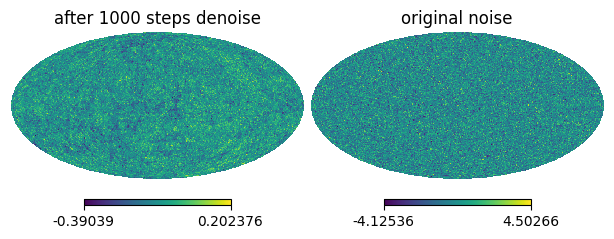

In [55]:
fig = plt.figure(figsize=(6,4))
f1 = hp.mollview(imgs[-1], nest=True, fig=fig, title='after 1000 steps denoise', sub=(1,2,1))
f2 = hp.mollview(diffused_sample, nest=True, fig=fig, title='original noise', sub=(1,2,2))

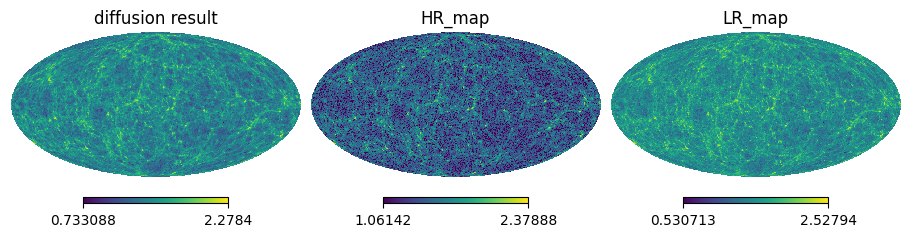

In [48]:
fig = plt.figure(figsize=(9,4))
p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,3,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,3,2))
p3 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR_map', sub=(1,3,3))
fig.show()

In [49]:


lmax = 64*3

input_cl =hp.sphtfunc.anafast(t2hpr(res), lmax=lmax)
output_cl =hp.sphtfunc.anafast(t2hpr(original_sample + lr_sample), lmax=lmax)
target_cl =hp.sphtfunc.anafast(t2hpr(lr_sample), lmax=lmax)

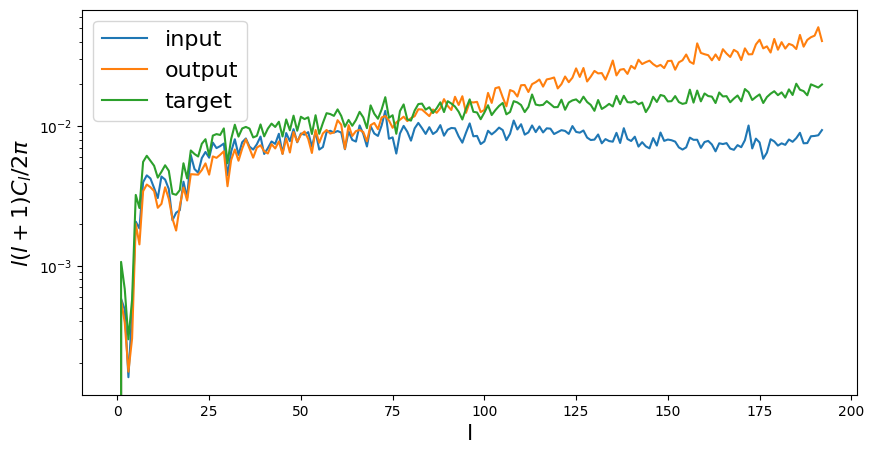

In [51]:
plot_ps(input_cl, output_cl, target_cl)

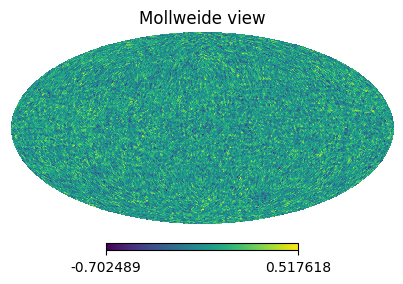

In [60]:
fig = plt.figure(figsize=(4,4))
c = hp.mollview(imgs[0], nest=True,  fig=fig)
plt.show()

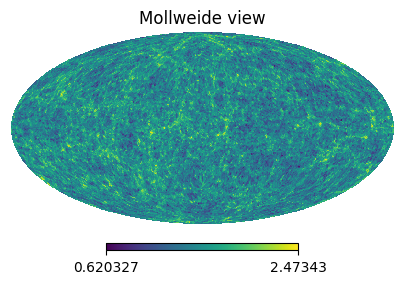

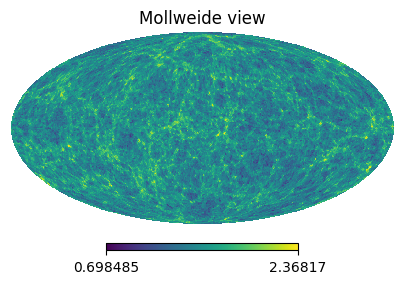

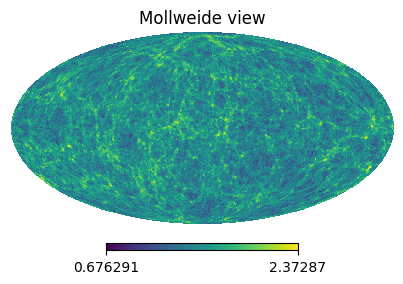

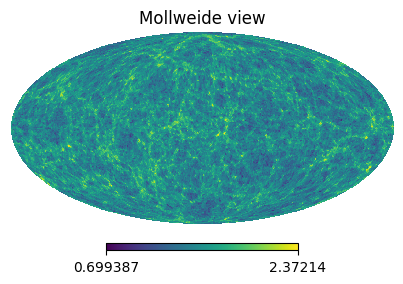

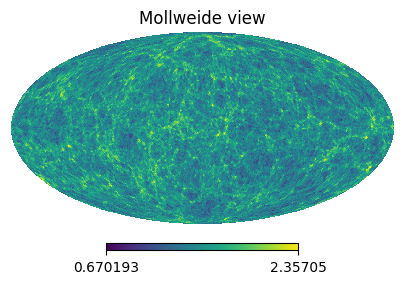

In [58]:
n = 5
tick = 500//n
for i in range(n):
    fig = plt.figure(figsize=(4,4))
    c = hp.mollview(np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0])+imgs[tick*i], nest=True,  fig=fig)
    plt.show()

In [58]:
dfs = model.diffusion

In [69]:
shape = tmp_sample.shape
b = shape[0]
img = torch.randn(shape, device=device)
imgs = []
for i in tqdm(reversed(range(0, dfs.timesteps, 10)), desc='sampling loop time step', total=dfs.timesteps//10):
    img = dfs.p_sample(model.model, img, torch.full((b,), i, device=device, dtype=torch.long), tmp_lr, i, None).detach()
    imgs.append(img.cpu().numpy())

sampling loop time step: 100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


In [77]:
res = np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0]) + np.hstack(imgs[-1][:48, : , 0])

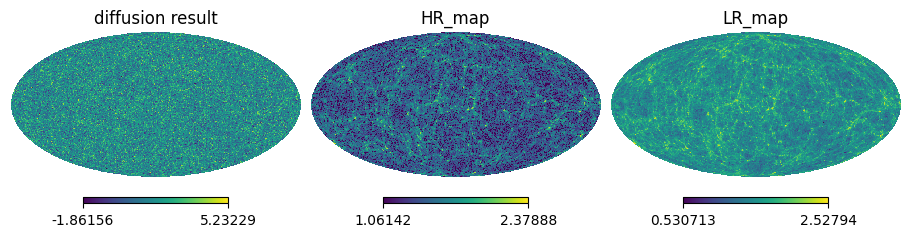

In [79]:
fig = plt.figure(figsize=(9,4))
p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,3,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,3,2))
p3 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR_map', sub=(1,3,3))
fig.show()

# statistics

In [72]:
import glob
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [91]:
def plot_sample(mapdir, fname):
    input = hp.fitsfunc.read_map(f'{mapdir}/input.fits')
    output = hp.fitsfunc.read_map(f'{mapdir}/output.fits')
    target = hp.fitsfunc.read_map(f'{mapdir}/target.fits')

    fig = plt.figure(figsize=(7, 9))
    # set min and max among input, output, and target
    tmp_min = round(np.min([np.min(input), np.min(output), np.min(target)]), 1)
    tmp_max = round(np.max([np.max(input), np.max(output), np.max(target)]), 1)
    hp.orthview(input, fig=fig, title=r'LR $64^3$', sub=(3, 1, 1), min=tmp_min, max=tmp_max)
    hp.orthview(output, fig=fig, title=r'SR $128^3$', sub=(3, 1, 2), min=tmp_min, max=tmp_max)
    hp.orthview(target, fig=fig, title=r'HR $128^3$', sub=(3, 1, 3), min=tmp_min, max=tmp_max)

    fig.savefig(fname, bbox_inches='tight', pad_inches=0.1, dpi=300)

In [56]:
def read_cl(cl_dir):
    input_cl = np.loadtxt(f'{cl_dir}/input_cl.txt')
    output_cl = np.loadtxt(f'{cl_dir}/output_cl.txt')
    target_cl = np.loadtxt(f'{cl_dir}/target_cl.txt')
    cls = [input_cl, output_cl, target_cl]

    input_cl_std = np.loadtxt(f'{cl_dir}/input_cl_std.txt')
    output_cl_std = np.loadtxt(f'{cl_dir}/output_cl_std.txt')
    target_cl_std = np.loadtxt(f'{cl_dir}/target_cl_std.txt')
    cl_stds = [input_cl_std, output_cl_std, target_cl_std]

    return cls, cl_stds

In [85]:
def plot_powerspec(cls, cl_stds, fname):
    fig, ax = plt.subplots(figsize=(7, 4))
    labels = [r"LR $64^3$", r"SR $128^3$", r"HR $128^3$"]
    colors = ["tab:blue", "tab:orange", "tab:green"]
    ax.set_title(r"Power spectrum, $N_\mathrm{side}=64$", fontsize=12)
    for i, cl in enumerate(cls):
        if i == 0:
            ell = np.arange(len(cl))
        tmp_ps = (ell*(ell+1)*cl/(2*np.pi))
        tmp_std = (ell*(ell+1)*cl_stds[i]/(2*np.pi))
        ax.fill_between(ell, (tmp_ps-tmp_std), (tmp_ps+tmp_std), alpha=0.3, color=colors[i])
        ax.plot(ell, tmp_ps, label=labels[i], color=colors[i])
        
    ax.set_xlabel("l", fontsize=16)
    ax.set_ylabel(r"$\mathrm{l(l+1)C_{l}/2\pi}\;\; $", fontsize=12)
    ax.set_yscale("log")
    ax.set_ylim(1e-3, 1e-1)
    ax.legend(fontsize=12)

    
    fig.savefig(fname, bbox_inches='tight', pad_inches=0.1, dpi=300)

In [23]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

In [78]:
def powerspec(diff, lr, n_maps, patch_size, lmax, data_dir=None, save_first=True):
    input_cl =[]
    output_cl =[]
    target_cl =[]
    if data_dir is None:
        raise ValueError('data_dir must be specified')
    stats_dir = f"{data_dir}/stats"
    if not os.path.exists(stats_dir):
            os.makedirs(stats_dir)
        
    for i in tqdm(range(n_maps), desc='power spectrum loop'):
        fname = f"{data_dir}/diffused_{i}.fits"
        tmp_lr = np.hstack(lr[patch_size*i:patch_size*(i+1)].detach().cpu().numpy()[:, : , 0])
        tmp_sample = np.hstack(diff[patch_size*i:patch_size*(i+1)].detach().cpu().numpy()[:, : , 0])
        tmp = hp.read_map(fname)
        y_hat= t2hpr(tmp_lr + tmp)
        y = t2hpr(tmp_lr + tmp_sample)
        x = t2hpr(tmp_lr)        
        if save_first and i == 0:
            img_dir =  f"{data_dir}/img"
            if not os.path.exists(img_dir):
                os.makedirs(img_dir)
            hp.fitsfunc.write_map(f'{img_dir}/input.fits', x, overwrite=True, dtype=np.float64)
            hp.fitsfunc.write_map(f'{img_dir}/output.fits', y_hat, overwrite=True, dtype=np.float64)
            hp.fitsfunc.write_map(f'{img_dir}/target.fits', y, overwrite=True, dtype=np.float64)
        input_cl.append(hp.sphtfunc.anafast(x, lmax=lmax))
        output_cl.append(hp.sphtfunc.anafast(y_hat, lmax=lmax))
        target_cl.append(hp.sphtfunc.anafast(y, lmax=lmax))
        input_cl_mean = np.mean(input_cl, axis=0)
        output_cl_mean = np.mean(output_cl, axis=0)
        target_cl_mean = np.mean(target_cl, axis=0)
        input_cl_std = np.std(input_cl, axis=0)
        output_cl_std = np.std(output_cl, axis=0)
        target_cl_std = np.std(target_cl, axis=0)

    # Save the power spectrum
    np.savetxt(f'{stats_dir}/input_cl.txt', input_cl_mean)
    np.savetxt(f'{stats_dir}/output_cl.txt', output_cl_mean)
    np.savetxt(f'{stats_dir}/target_cl.txt', target_cl_mean)
    np.savetxt(f'{stats_dir}/input_cl_std.txt', input_cl_std)
    np.savetxt(f'{stats_dir}/output_cl_std.txt', output_cl_std)
    np.savetxt(f'{stats_dir}/target_cl_std.txt', target_cl_std)

    return [input_cl, output_cl, target_cl]

In [79]:
data_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/srsphere/diffusion/result"

In [80]:
res_dir = glob.glob(f"{data_dir}/diffusionmaps/*fits")
n_maps=len(res_dir)

nside =64
patch_size = 12*2**2
lmax = nside*3

In [81]:
input_cl, output_cl, target_cl = powerspec(combined_dataset.tensors[0], combined_dataset.tensors[1], 
          n_maps, patch_size, lmax, data_dir=data_dir, save_first=True)

power spectrum loop: 100%|██████████| 100/100 [00:02<00:00, 44.50it/s]


In [82]:
stats_dir = f"{data_dir}/stats"
cls, cl_stds = read_cl(stats_dir)

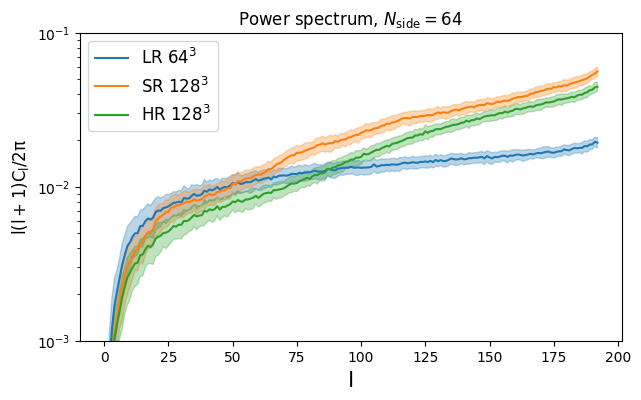

In [86]:
img_dir =  f"{data_dir}/img"
plot_powerspec(cls, cl_stds, fname=f"{img_dir}/powerspec.png")

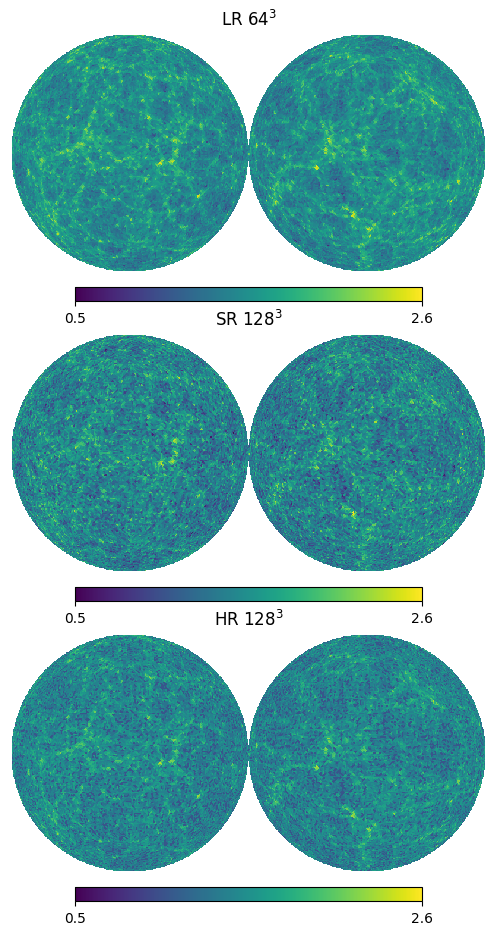

In [92]:
plot_sample(img_dir, fname=f"{img_dir}/sample.png")